In [2]:
!git clone -b Final --single-branch https://github.com/JakubSzczepanowski/BrainTumorSegmentation.git

Cloning into 'BrainTumorSegmentation'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 185 (delta 112), reused 138 (delta 65), pack-reused 0 (from 0)
Receiving objects: 100% (185/185), 3.95 MiB | 26.45 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [3]:
!pip install tensorflow_wavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.1 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
!pip install keras==3.0.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [5]:
import tensorflow as tf
import numpy as np
import os
import BrainTumorSegmentation.dataloader as dataloader
import BrainTumorSegmentation.metrics as metrics
import BrainTumorSegmentation.architecture as architecture
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import tensorflow_wavelets.Layers.DWT as DWT

2024-09-01 15:54:53.233562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 15:54:53.233653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 15:54:53.373493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


keras_3


In [6]:
ROOT_DIR = '.'
DATA_DIR = '../input/brats2018'
LABELED_DIR = 'MICCAI_BraTS_2018_Data_Training'
UNLABELED_DIR = 'MICCAI_BraTS_2018_Data_Validation'
LABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, LABELED_DIR)
UNLABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, UNLABELED_DIR)

BATCH_SIZE = 80
OFFSET = (35, 40)
BRAIN_SLICES = 8
NUM_CLASSES = 4
X_DTYPE = np.float32
Y_DTYPE = np.uint8
MAX_VALUE = 32767

In [7]:
paths, sizes = dataloader.load_dataset_paths(LABELED_PATH, UNLABELED_PATH)

In [8]:
train_brains, val_brains, test_brains, unlabeled_brains = paths
hgg_train_size, lgg_train_size, hgg_val_size, lgg_val_size = sizes
hgg_train_size, lgg_train_size

(142, 50)

In [9]:
train_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[train_brains, MAX_VALUE, BATCH_SIZE, BRAIN_SLICES, False, False, False, OFFSET, hgg_train_size, lgg_train_size, True, 10]) # 80, 40, 20, 10 różnorodność: 1, 2, 4, 8

In [10]:
val_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[val_brains, MAX_VALUE, BATCH_SIZE, BRAIN_SLICES, False, False, False, OFFSET, hgg_val_size, lgg_val_size, True, 10])

In [11]:
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [12]:
csv_logger_callback = tf.keras.callbacks.CSVLogger('diunet_v4.1_dice_kontekstualne_10_1.1.csv', append=True)

In [13]:
cutted_frames = dataloader.BRAIN_FRAMES - sum(OFFSET)
steps_per_epoch = len(train_brains) * (cutted_frames // BATCH_SIZE)
val_steps_per_epoch = len(val_brains) * (cutted_frames // BATCH_SIZE)

In [14]:
model = architecture.build_diunet((dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), NUM_CLASSES)
model.compile(loss=metrics.f1_loss, optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.00001), metrics=['accuracy',
                                                                                               tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[0]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[1]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[2]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[3]),
                                                                                               tf.keras.metrics.Precision(class_id=0),
                                                                                               tf.keras.metrics.Precision(class_id=1),
                                                                                               tf.keras.metrics.Precision(class_id=2),
                                                                                               tf.keras.metrics.Precision(class_id=3),
                                                                                               tf.keras.metrics.Recall(class_id=0),
                                                                                               tf.keras.metrics.Recall(class_id=1),
                                                                                               tf.keras.metrics.Recall(class_id=2),
                                                                                               tf.keras.metrics.Recall(class_id=3)])

In [15]:
checkpoint_filepath = os.path.join(ROOT_DIR, 'diunet_v4.1_dice_kontekstualne_10_1.6', 'model_checkpoint_epoch_{epoch:02d}.keras')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

In [40]:
model.optimizer.learning_rate.assign(0.0000001) # zmiana współczynnika uczenia
print(model.optimizer.learning_rate.numpy())

1e-07


In [27]:
model = tf.keras.models.load_model("/kaggle/working/diunet_v4.1_dice_kontekstualne_10_1.6/model_checkpoint_epoch_10.keras", custom_objects={"f1_loss": f1_loss, 'DropBlock2D': DropBlock2D, 'CBAM':CBAM, 'DWT_Layer':DWT_Layer})

In [42]:
history = model.fit(train_dataset, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=val_dataset, validation_steps=val_steps_per_epoch, callbacks=[checkpoint_callback, csv_logger_callback])

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9928 - loss: 0.2327 - one_hot_io_u: 0.9680 - one_hot_io_u_1: 0.5705 - one_hot_io_u_2: 0.5339 - one_hot_io_u_3: 0.6373 - one_hot_mean_io_u: 0.6774 - precision: 0.9971 - precision_1: 0.7313 - precision_2: 0.7737 - precision_3: 0.8234 - recall: 0.9985 - recall_1: 0.7217 - recall_2: 0.6325 - recall_3: 0.7383
Epoch 1: saving model to ./diunet_v4.1_dice_kontekstualne_10_1.6/model_checkpoint_epoch_01.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.9928 - loss: 0.2327 - one_hot_io_u: 0.9679 - one_hot_io_u_1: 0.5705 - one_hot_io_u_2: 0.5338 - one_hot_io_u_3: 0.6373 - one_hot_mean_io_u: 0.6774 - precision: 0.9971 - precision_1: 0.7313 - precision_2: 0.7737 - precision_3: 0.8233 - recall: 0.9985 - recall_1: 0.7217 - recall_2: 0.6324 - recall_3: 0.7383 - val_accuracy: 0.9886 - val_loss: 0.3147 - val_one_hot_io_u: 0.9693 - val_one_hot_io_u_1: 0.4711 - val_one_hot_io_u_2: 0.4733 - val_one_hot_io_u_3: 0.4122 - val_one_hot_

In [45]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [46]:
download_file('/kaggle/working/diunet_v4.1_dice_kontekstualne_10_1.6/model_checkpoint_epoch_10.keras', 'diunet_v4.1_dice_kontekstualne_10_1.6')

/kaggle/working/diunet_v4.1_dice_kontekstualne_10_1.6.zip

In [43]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'diunet_v4.1_dice_kontekstualne_10_1.6/diunet_v4.1_dice_kontekstualne_10_1.6.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


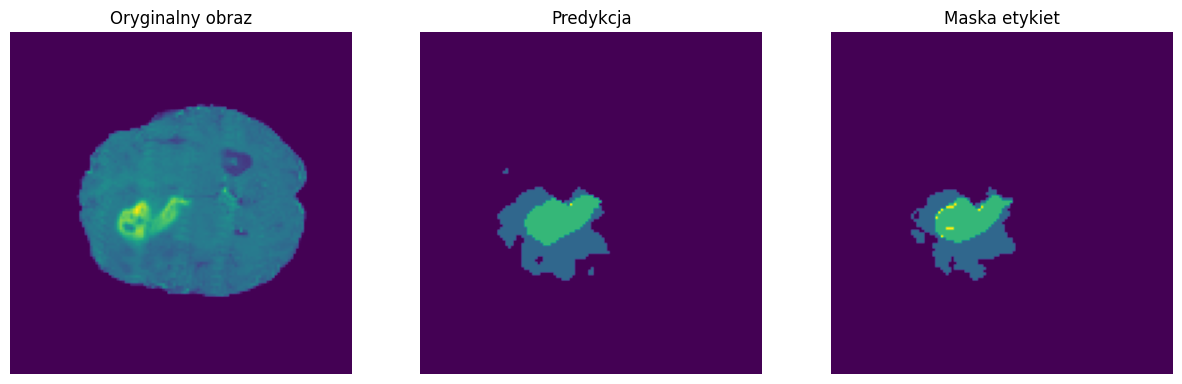

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


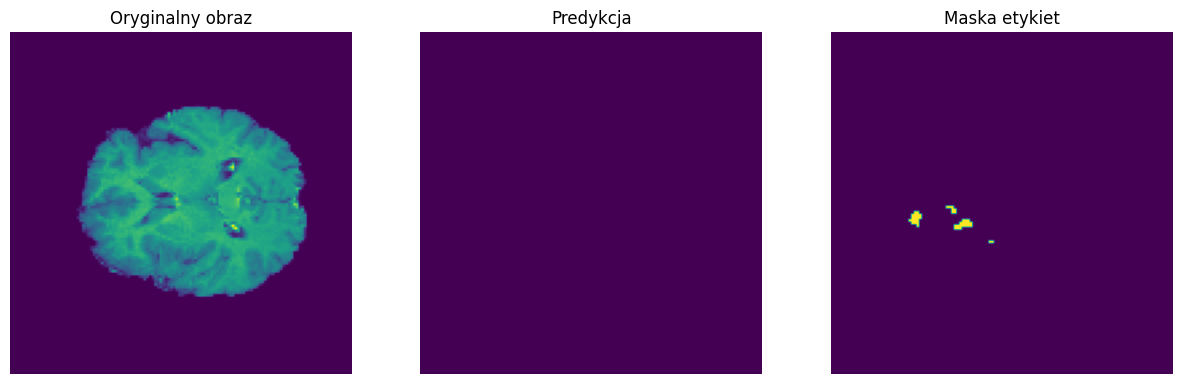

In [32]:
import matplotlib.pyplot as plt

i = 0
for batch_X, batch_Y in test_dataset.take(44):
    if i == 0 or i == 43:
        y_pred = model.predict(batch_X)
        predictions = np.argmax((y_pred[70] > 0.5).astype(int), axis=-1)
        ground_truth = np.argmax(batch_Y[70], axis=-1)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(batch_X[70, :, :, 0])
        axs[0].set_title('Oryginalny obraz')
        axs[0].axis('off')

        axs[1].imshow(predictions)
        axs[1].set_title('Predykcja')
        axs[1].axis('off')

        axs[2].imshow(ground_truth)
        axs[2].set_title('Maska etykiet')
        axs[2].axis('off')
        if i == 43:
            plt.savefig('drobne_lgg.png')
        plt.show()
    i += 1

In [29]:
test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[test_brains, MAX_VALUE, dataloader.BRAIN_FRAMES, 1, False, False, True, (0, 0), hgg_train_size, lgg_train_size, False, 0])

In [39]:
model.evaluate(test_dataset, steps=len(test_brains))

44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9957 - loss: 0.2688 - one_hot_io_u: 0.9877 - one_hot_io_u_1: 0.5894 - one_hot_io_u_2: 0.6530 - one_hot_io_u_3: 0.5477 - one_hot_mean_io_u: 0.6945 - precision: 0.9977 - precision_1: 0.7734 - precision_2: 0.8426 - precision_3: 0.8592 - recall: 0.9991 - recall_1: 0.7125 - recall_2: 0.7438 - recall_3: 0.5983


[0.3423711955547333,
 0.994265615940094,
 0.9728878736495972,
 0.49827516078948975,
 0.573215901851654,
 0.4551769495010376,
 0.624889075756073,
 0.9965917468070984,
 0.7109353542327881,
 0.8409414887428284,
 0.8249009251594543,
 0.9991841316223145,
 0.6251570582389832,
 0.6427503228187561,
 0.5035880208015442]

In [30]:
test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[test_brains, MAX_VALUE, dataloader.BRAIN_FRAMES, 1, False, False, False, (0, 0), hgg_train_size, lgg_train_size, False, 0])

In [31]:
model.evaluate(test_dataset, steps=len(test_brains))

2024-08-29 12:39:05.228966: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1097600: 6.58343, expected 5.77899
2024-08-29 12:39:05.229261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1146752: 7.4841, expected 6.56566
2024-08-29 12:39:05.241768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4227072: 8.21086, expected 7.22475
2024-08-29 12:39:05.241885: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4243456: 8.03639, expected 7.11795
2024-08-29 12:39:05.246442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5374079: 8.00815, expected 7.02204
2024-08-29 12:39:05.250010: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6209536: 7.82798, expected 6.90954
2024-08-29 12:39:05.252143: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6717312: 7.70989, expected 6.79145
2024-08-29 12:

44/44 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.9955 - loss: 0.2707 - one_hot_io_u: 0.9879 - one_hot_io_u_1: 0.5836 - one_hot_io_u_2: 0.6414 - one_hot_io_u_3: 0.5449 - one_hot_mean_io_u: 0.6894 - precision: 0.9979 - precision_1: 0.7584 - precision_2: 0.7997 - precision_3: 0.8446 - recall: 0.9988 - recall_1: 0.7171 - recall_2: 0.7647 - recall_3: 0.6026


[0.33675894141197205,
 0.9941903352737427,
 0.9734530448913574,
 0.4976235330104828,
 0.5556719899177551,
 0.46671101450920105,
 0.6233649253845215,
 0.9968370795249939,
 0.6978917121887207,
 0.7981874346733093,
 0.8156013488769531,
 0.9990267157554626,
 0.6343583464622498,
 0.6465551257133484,
 0.5214619040489197]

In [32]:
train_test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[train_brains, MAX_VALUE, dataloader.BRAIN_FRAMES, 1, False, False, True, (0, 0), hgg_train_size, lgg_train_size, False, 0])

In [33]:
model.evaluate(train_test_dataset, steps=len(train_brains))

192/192 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.9964 - loss: 0.2653 - one_hot_io_u: 0.9643 - one_hot_io_u_1: 0.6252 - one_hot_io_u_2: 0.6602 - one_hot_io_u_3: 0.4930 - one_hot_mean_io_u: 0.6857 - precision: 0.9980 - precision_1: 0.8127 - precision_2: 0.8309 - precision_3: 0.8070 - recall: 0.9993 - recall_1: 0.7315 - recall_2: 0.7623 - recall_3: 0.5574


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.26877304911613464,
 0.9962154626846313,
 0.9395344257354736,
 0.6171911954879761,
 0.6500241756439209,
 0.5260825157165527,
 0.6832081079483032,
 0.9980407357215881,
 0.7971774935722351,
 0.8220290541648865,
 0.8108845949172974,
 0.9991921782493591,
 0.7322950959205627,
 0.7564086318016052,
 0.5995050668716431]

In [34]:
train_test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[train_brains, MAX_VALUE, dataloader.BRAIN_FRAMES, 1, False, False, False, (0, 0), hgg_train_size, lgg_train_size, False, 0])

In [35]:
model.evaluate(train_test_dataset, steps=len(train_brains))

192/192 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.9963 - loss: 0.2691 - one_hot_io_u: 0.9637 - one_hot_io_u_1: 0.6114 - one_hot_io_u_2: 0.6447 - one_hot_io_u_3: 0.5029 - one_hot_mean_io_u: 0.6807 - precision: 0.9981 - precision_1: 0.8035 - precision_2: 0.7981 - precision_3: 0.8023 - recall: 0.9992 - recall_1: 0.7201 - recall_2: 0.7703 - recall_3: 0.5728


[0.27241456508636475,
 0.9960712194442749,
 0.938637912273407,
 0.6058877110481262,
 0.6308326125144958,
 0.5349751710891724,
 0.6775834560394287,
 0.9980959892272949,
 0.7884575128555298,
 0.7885759472846985,
 0.8004316091537476,
 0.9990922212600708,
 0.7235249280929565,
 0.7593438625335693,
 0.617211103439331]

In [36]:
val_test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[val_brains, MAX_VALUE, dataloader.BRAIN_FRAMES, 1, False, False, True, (0, 0), hgg_train_size, lgg_train_size, False, 0])

In [37]:
model.evaluate(val_test_dataset, steps=len(val_brains))

49/49 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9954 - loss: 0.2837 - one_hot_io_u: 0.9872 - one_hot_io_u_1: 0.5923 - one_hot_io_u_2: 0.5980 - one_hot_io_u_3: 0.4252 - one_hot_mean_io_u: 0.6507 - precision: 0.9975 - precision_1: 0.8190 - precision_2: 0.7578 - precision_3: 0.7058 - recall: 0.9993 - recall_1: 0.6820 - recall_2: 0.7400 - recall_3: 0.5158


[0.31991925835609436,
 0.994322657585144,
 0.9702338576316833,
 0.5451403856277466,
 0.5752452611923218,
 0.3933790624141693,
 0.6209996938705444,
 0.9968554973602295,
 0.7639614939689636,
 0.7398720979690552,
 0.7305501699447632,
 0.9989630579948425,
 0.6557646989822388,
 0.7214503884315491,
 0.46025651693344116]

In [38]:
val_test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[val_brains, MAX_VALUE, dataloader.BRAIN_FRAMES, 1, False, False, False, (0, 0), hgg_train_size, lgg_train_size, False, 0])

In [39]:
model.evaluate(val_test_dataset, steps=len(val_brains))

49/49 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9952 - loss: 0.2877 - one_hot_io_u: 0.9868 - one_hot_io_u_1: 0.5805 - one_hot_io_u_2: 0.5912 - one_hot_io_u_3: 0.4163 - one_hot_mean_io_u: 0.6437 - precision: 0.9975 - precision_1: 0.8039 - precision_2: 0.7370 - precision_3: 0.7051 - recall: 0.9992 - recall_1: 0.6765 - recall_2: 0.7497 - recall_3: 0.5020


[0.3267132639884949,
 0.9941297769546509,
 0.9696255922317505,
 0.5339986681938171,
 0.5551181435585022,
 0.39141467213630676,
 0.6125393509864807,
 0.9968491196632385,
 0.7515109181404114,
 0.7235069870948792,
 0.7199406027793884,
 0.9988816380500793,
 0.648542046546936,
 0.7051595449447632,
 0.4616641402244568]

In [ ]:
import nibabel as nib
import cv2

all_y_true = [[], [], [], []]
all_y_pred = [[], [], [], []]

for path in test_brains:
    path = dataloader.extend_path_from_last_part(path)
    t1ce = nib.load(f'{path}_t1ce.nii').get_fdata(dtype=X_DTYPE)
    flair = nib.load(f'{path}_flair.nii').get_fdata(dtype=X_DTYPE)
    seg = nib.load(f'{path}_seg.nii').get_fdata(dtype=X_DTYPE)

    batch_X = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE)
    batch_Y = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE), dtype=Y_DTYPE)

    for i in range(dataloader.BRAIN_FRAMES):
        batch_X[i, :, :, 0] = cv2.resize(t1ce[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
        batch_X[i, :, :, 1] = cv2.resize(flair[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
        y_map = dataloader.DataGenerator._map_labels(seg[:, :, i])
        batch_Y[i, :, :] = cv2.resize(y_map, (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))

    batch_Y = tf.one_hot(batch_Y, 4, dtype=Y_DTYPE)
    batch_X = batch_X/MAX_VALUE

    y_pred = model.predict(batch_X)
    
    for i in range(NUM_CLASSES):
        all_y_true[i].append(batch_Y[:, :, :, i].numpy().flatten())
        all_y_pred[i].append(y_pred[:, :, :, i].flatten())

In [29]:
with open('diunet_v4.1_dice_kontekstualne_10_1.6_preds.pickle', 'wb') as handle:
    pickle.dump([all_y_true, all_y_pred], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
roc = []
for i in range(NUM_CLASSES):
    fpr, tpr, thresholds = roc_curve(np.concatenate(all_y_true[i]), np.concatenate(all_y_pred[i]))
    roc.append((fpr, tpr, thresholds))

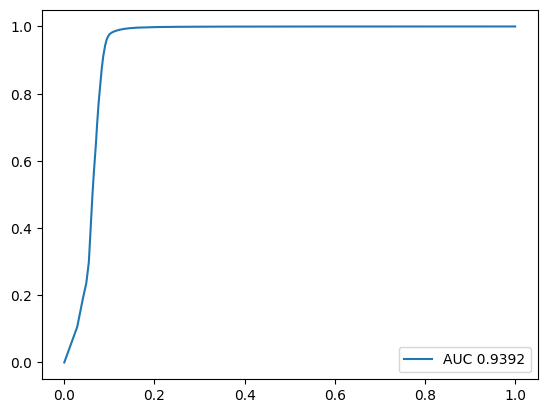

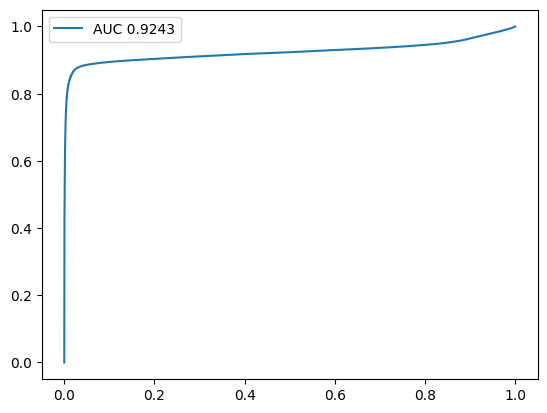

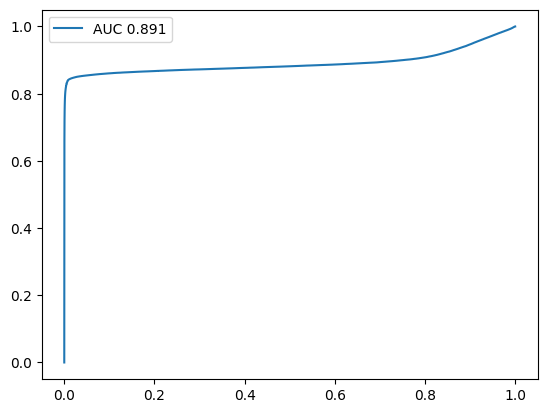

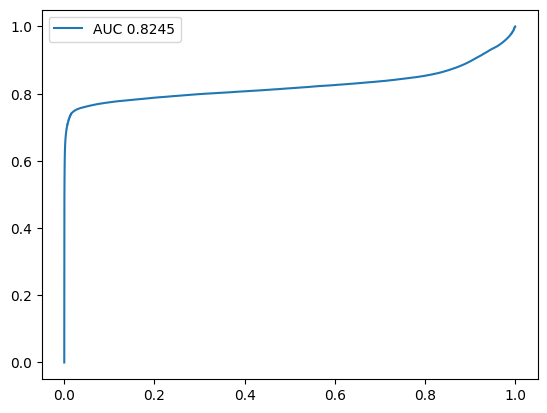

In [37]:
for i in range(NUM_CLASSES):
    fpr, tpr, thresholds = roc[i]
    roc.append((fpr, tpr, thresholds))
    plt.plot(fpr, tpr, label=f'AUC {round(auc(fpr, tpr), 4)}')
    plt.legend()
    plt.savefig(f'roc_{i}.png')
    plt.show()

In [2]:
with open('/kaggle/working/diunet_v4.1_dice_kontekstualne_10_1.6_preds.pickle', 'rb') as handle:
    all_y_true, all_y_pred = pickle.load(handle)

In [8]:
pr = []
for i in range(NUM_CLASSES):
    precision, recall, thresholds_pr = precision_recall_curve(np.concatenate(all_y_true[i]), np.concatenate(all_y_pred[i]))
    pr.append((precision, recall, thresholds_pr))

In [9]:
with open('diunet_v4.1_dice_kontekstualne_10_1.6_pr.pickle', 'wb') as handle:
    pickle.dump(pr, handle, protocol=pickle.HIGHEST_PROTOCOL)

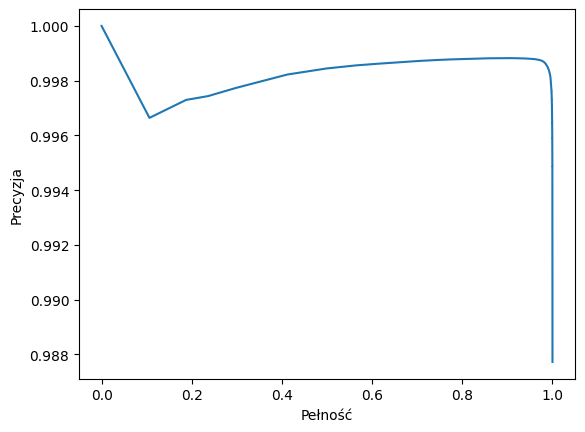

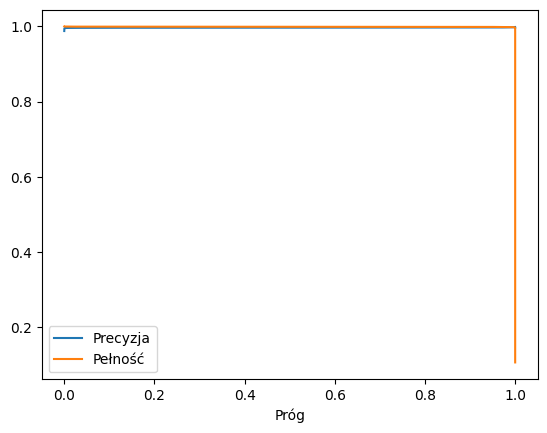

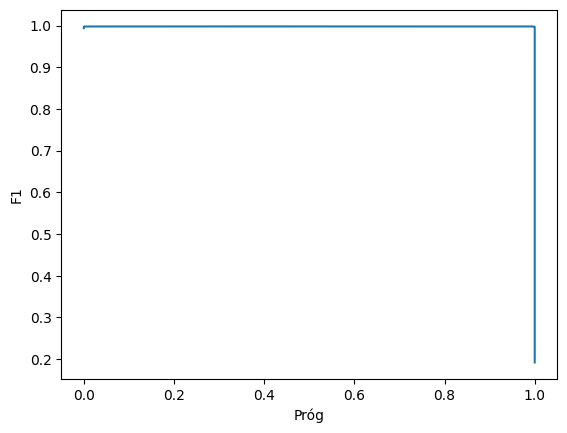

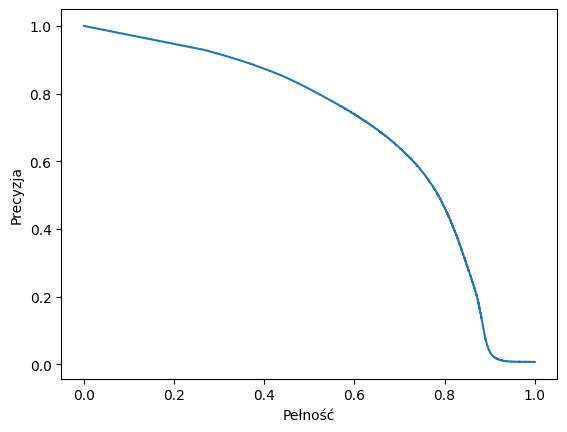

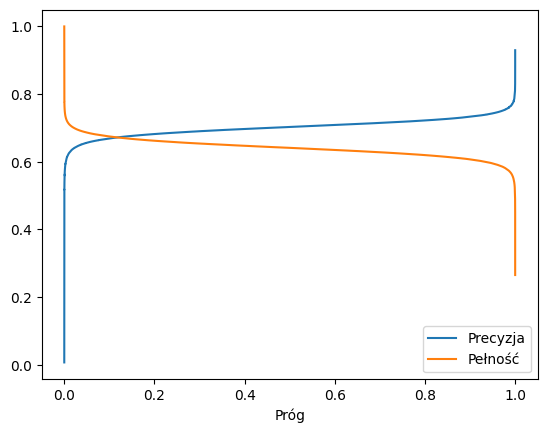

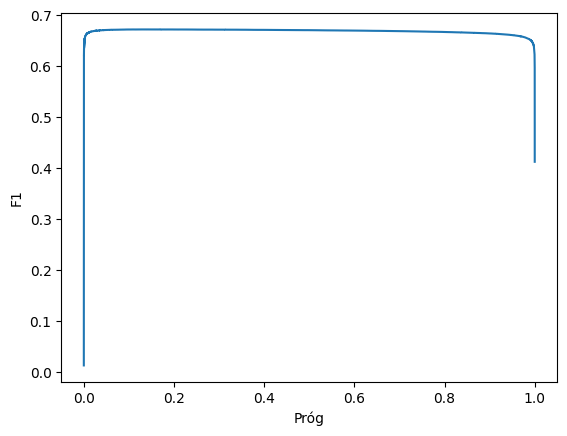

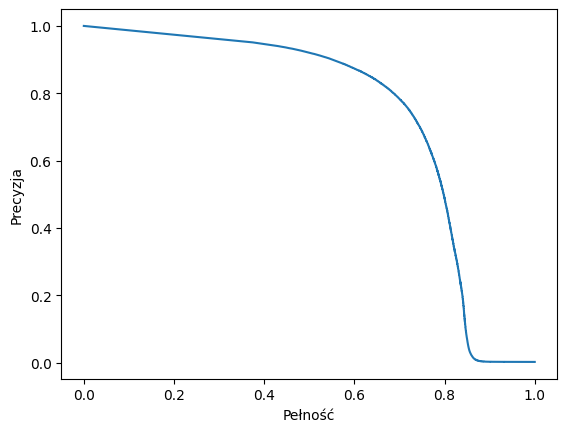

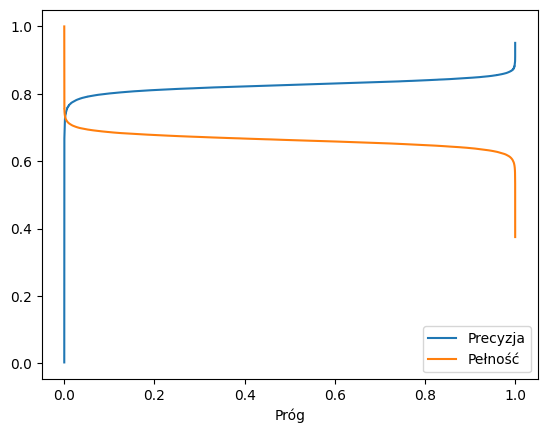

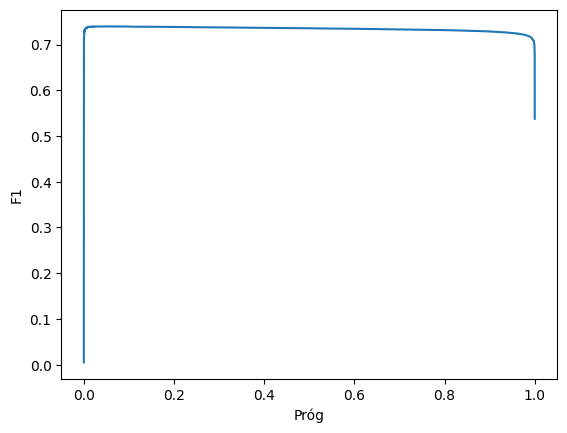

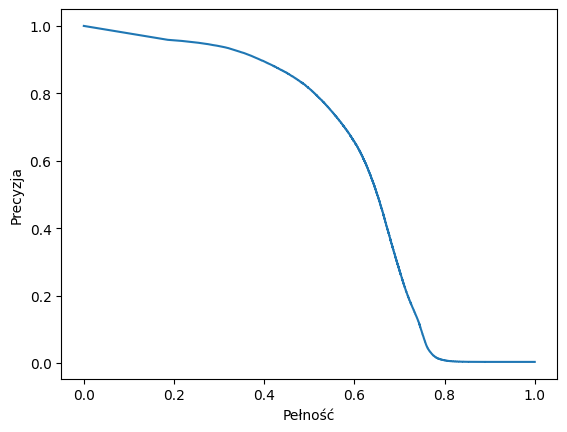

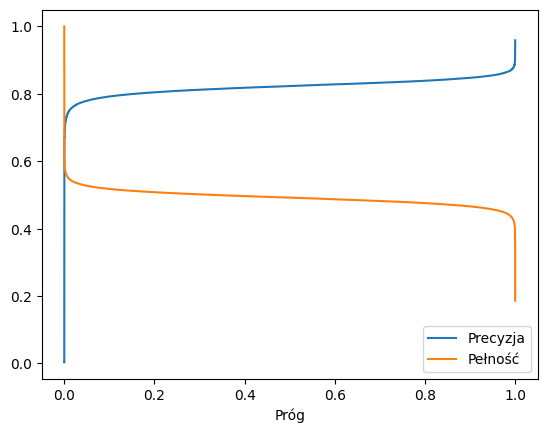

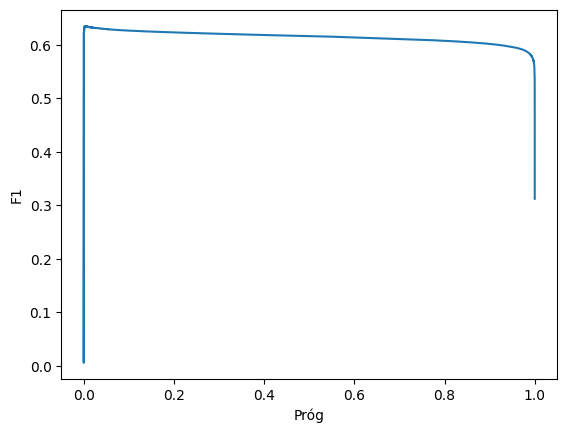

In [12]:
for i in range(NUM_CLASSES):
    precision, recall, thresholds_pr = pr[i]
    plt.plot(recall, precision)
    plt.xlabel('Pełność')
    plt.ylabel('Precyzja')
    plt.savefig(f'precision_recall_{i}.png')
    plt.show()
    plt.plot(thresholds_pr, precision[:-1], label='Precyzja')
    plt.plot(thresholds_pr, recall[:-1], label='Pełność')
    plt.xlabel('Próg')
    plt.legend()
    plt.show()
    f1_scores = np.where((precision + recall) != 0,
                         2 * (precision * recall) / (precision + recall),
                         0)
    plt.plot(thresholds_pr, f1_scores[:-1])
    plt.xlabel('Próg')
    plt.ylabel('F1')
    plt.show()